# Recession Forecaster

The United States as of today (October, 2019) has experienced the longest expansion cycle, yet the there are constant talks in the news about an impending recession. Yes, there are signs, such as the recent yield curve inversion, the market corrections in 2018 & 2019, etc. Recessions happen every 10 years or so, are we overdue for one?

The first part is to predict GDP growth using regression, because NBER defines a recession as ["a significant decline in economic activity"](https://www.nber.org/cycles.html), not 2 consequtive quarters of deline in real GDP. The second part is to return a probabilistic model based on classification, similar to the [Bloomberg Recession Tracker](https://www.bloomberg.com/graphics/us-economic-recession-tracker/).

## Part 1

### Feature Selection

While there are techniques and algorithms to systematically select variables, this is outside the scope of this analysis. Instead, we will rely on domain knowledge. The following factors are considered when selecting input variables:
* Having sufficient data, as recessions are rare occurances.
* Having forward predictive power, which means inflection changes should occur before occur simultaneously as inflection changes in GDP.
* Represent various aspects or mechanisms of the economy, such as a risk free benchmark.
* Avoid composite models or indices, as the goal is to construct our own model.

This selection is not final, as the model may dictate the addition or removal of certain variables.

For the GDP decision variable:
* [**Real Gross Domestic Product**](https://fred.stlouisfed.org/series/GDPC1)- Inflation adjusted value of goods and services produced in a year.

For equities, the following variables are considered:
* [S&P 500](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC)- Weighted stock index of 500 companies listed on US exchanges with the largest market cap.
* [**S&P 500 Cyclically Adjusted PE Ratio**](https://www.quandl.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-Shiller-PE-Ratio-by-Month) [(info)](https://www.investopedia.com/terms/c/cape-ratio.asp)- Normalizes PE ratio fluctuations over 10 year inflation-adjusted earnings. This indicator is used to gauge whether the equities market is over or under-valued.
* [**Nonfinancial Corporate Debt as Percentage of Equity**](https://fred.stlouisfed.org/series/NCBCMDPMVCE)- Contains companies outside of the S&P500. Constructed using balance sheet valuations.

For bonds, the following variables are considered: 
* [10 Year Constant Maturity Minus 3 Month Treasuries Yield Spread](https://fred.stlouisfed.org/series/T10Y3M)- Federal Reserve's main methodology. Financial institutions borrow at low rates short term, to lend at high rates long term. Long term treasury yield tends to be stable, but short term yields are more volatile, and subject to [Federal Reserve interventions](https://fredblog.stlouisfed.org/2017/02/lets-do-the-twist/). The data only goes back to 1982, which is not enough to train this model.
* [**10 Year Constant Maturity Minus 3 Month Treasuries Secondary Market Yield Spread**](https://fred.stlouisfed.org/series/TB3MS)- Makes up for the lack of data in the primary market. Primary and secondary market spreads are very close today, due to increased efficiency from electronic trading. Historically, the spread has been higher.
* [10 Year Treasuries Constant Maturity Rate](https://fred.stlouisfed.org/series/DGS10)- Long term treasuries usually reflect investor sentiment regarding long term economic growth. However, this metric alone does not provide evidence of short term liquidity.
* 3 Months Outstanding Repo [(info)](http://law.emory.edu/ecgar/content/volume-5/issue-2/essays/repo-recession-financial-regulation.html)- Before the Great Recession, investment banks used short term repo to inject liquidity to stay afloat. Uptick in short term repo may indicate credit crunch. FRED only has records of contracts with itself as a participant, leaving out the majority of transactions. Data on market transactions were difficult to find.

For inflation, the following indicators are considered:
* [**Consumer Price Index for Urban Consumers**](https://fred.stlouisfed.org/series/CPIAUCSL) [(info)](https://www.bls.gov/opub/btn/volume-3/why-does-bls-provide-both-the-cpi-w-and-cpi-u.htm)- Price inflation covering 88% of Americans, calculated from expenditures. Uses a survey to calculate the basket of goods and services. Basket is updated every 2 years. Selected due to difficulty quantifying intangible traits such as quality.
* [Chained Consumper Price Index for Urban Consumers](https://fred.stlouisfed.org/series/SUUR0000SA0) [(info)](https://www.brookings.edu/blog/up-front/2017/12/07/the-hutchins-center-explains-the-chained-cpi/)- Similar to CPI-U, but considers substitution purchases, and weights the changes every month. Lacking long term data.

For employment, the following indicators are considered:
* [Labor Participation Rate](https://fred.stlouisfed.org/series/CIVPART)- Percent of population over 16 actively seeking or engaged in employment. Strongly driven by demographic trends, such as women participation in the workforce, or retirement of Baby Boomers.
* [**Total Nonfarm Payroll**](https://fred.stlouisfed.org/series/PAYEMS)- Size of the labor force, accounting for 80% of workers who contribute to GDP, excluding propritors, unpaid volunteers, or farm workers.
* [Wage Growth](https://fred.stlouisfed.org/series/CES0500000003)- When labor demand outstrips supply, wages increase, and vise versa. Lack of long term data.

Lastly, the following indicators are not placed in any categories above, but are included because of their predictive power.
* [**Real Private Gross Investment**](https://fred.stlouisfed.org/series/GPDIC1)- Investment represents expenditure on capital goods and residential properties. Provides an indicator for future productivity and GDP growth. Also a strong sign of economic recovery.

The following indicators were considered, but ultimately dismissed.
* [Purchaing Managers' Index](https://www.instituteforsupplymanagement.org/ismreport/mfgrob.cfm?SSO=1)- A survey of supply chain professionals in 19 primary industries. Locked behind paywall.
* [Composite Index of Leading Indicators](https://www.conference-board.org/data/bcicountry.cfm?cid=1) [(info)](https://www.investopedia.com/terms/c/cili.asp)- A composite index of 10 indicators. Locked behind paywall.
* [Consumer Confidence Index](https://www.conference-board.org/data/consumerconfidence.cfm)- A survey of consumer purchases and sentiments. Locked behind paywall.
* [VIX Volativity Index](https://fred.stlouisfed.org/series/VIXCLS)- Describes the volatility, but not the direction, of stocks.
* [Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FEDFUNDS)- FED has the most control of this rate, which means it is unfiltered by market forces. Secondly, FED pursued different doctrines throughout history, it was fighting inflation in the 70s, supporting deregulation in the 80s, inflation targeting in the 90s & 2000s, then quantitative easing in the 2010s.
* [Personal Savings Rate](https://fred.stlouisfed.org/series/PSAVERT)- Strongly driven by demographic trends, such as women entering workforce, or retirement of Baby Boomers.
* [Incremental Capital Outputs Ratio](https://www.investopedia.com/terms/i/icor.asp)- Calculates how much additional capital investment is needed to create growth. Hard to find on the web.

### Data Preparation

First, import the necessary packages.

In [1]:
import fredapi
import requests
import json
import numpy as np
import pandas as pd
import scipy
from functools import reduce
from math import ceil
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf
from copy import deepcopy
from dateutil.relativedelta import relativedelta

#### Import FRED Data

To import FRED data, we need an API key. API key can be requested [here](https://research.stlouisfed.org/docs/api/fred/).

Data returned by fredapi module are in "Series" format. We need to convert them to "DataFrame" format.
We will also rename the columns so the data become easier to manipulate.
Note some data are provided on a monthly frequency, while others are quarterly.

In [2]:
f = fredapi.Fred(api_key='8b91217446b6307d20cb5e4fcfba70eb') # remove API when done

def generate_fred_dataframe(name, series_url):
    return f.get_series(series_url).to_frame().reset_index().rename(columns={'index':'date', 0:name})

# monthly data.
tbill_3m = generate_fred_dataframe('tbill_3m', 'TB3MS')
tbill_10y = generate_fred_dataframe('tbill_10y', 'GS10')
cpiu = generate_fred_dataframe('cpiu', 'CPIAUCSL')
payroll = generate_fred_dataframe('payroll', 'PAYEMS')
# quarterly data
dtoe = generate_fred_dataframe('dtoe', 'NCBCMDPMVCE')
pinvest = generate_fred_dataframe('pinvest', 'GPDIC1')
gdp = generate_fred_dataframe('gdp', 'GDPC1')

#### Import Quandl Data

To process Quandl data, we have to:
1. reverse the order, so data is listed from oldest to newest;
2. rename columns;
3. set index column;
4. convert index to "datetime64" format, for compatibility with other data.

In [3]:
quandl_api_key = '8ufKe7Y2JMsYPU3CGN7m'

def generate_quandl_dataframe(name, series_url):
    res = pd.DataFrame.from_dict(requests.get(series_url.format(quandl_api_key)).json()['dataset']['data'])
    res = res[::-1].rename(columns={0:'date', 1:name})
    res['date'] = res['date'].astype('datetime64')
    return res

sp500_cape = generate_quandl_dataframe('sp500_cape', 'https://www.quandl.com/api/v3/datasets/MULTPL/SHILLER_PE_RATIO_MONTH.json?api_key={}')

#### Converting Quarterly to Monthly Data

To convert quarterly to monthly data, we will call the "resample" method.

In [4]:
dtoe = dtoe.set_index('date').resample('MS').asfreq()
pinvest = pinvest.set_index('date').resample('MS').asfreq()
gdp = gdp.set_index('date').resample('MS').asfreq()

#### Interpolate Null Values

Newly resampled months have null values, we will use [cublic spline interpolation](https://columbiaeconomics.com/2010/01/20/how-economists-convert-quarterly-data-into-monthly-cubic-spline-interpolation/), a technique commonly used by economists, to fill in the missing values. Cubic spline has better smoothing over quadratic interpolation.

Interpolation converts data to Series. We need to convert back to DataFrame type.

In [5]:
gdp['gdp'] = gdp['gdp'].interpolate(method='spline', order=3)
dtoe['dtoe'] = dtoe['dtoe'].interpolate(method='spline', order=3)
pinvest['pinvest'] = pinvest['pinvest'].interpolate(method='spline', order=3)

pinvest.head(2)

,pinvest
date,
1947-01-01,218.091000
1947-02-01,250.643025


#### Merge Datasets

Note that variables have different start dates, merging the datasets will automatically trim the start dates to April 1953, and the end date to April 2018, which should exclude any null values.

In [6]:
print(tbill_3m.head(1))
print(cpiu.head(1))

        date  tbill_3m
0 1934-01-01      0.72
        date   cpiu
0 1947-01-01  21.48


In [7]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500_cape, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data.isnull().sum()

tbill_3m      0
tbill_10y     0
cpiu          0
payroll       0
dtoe          0
pinvest       0
sp500_cape    0
gdp           0
dtype: int64

#### Deriving Treasury Spread

FRED has a graph, but not a series on [10 year - 3 month spread](https://fred.stlouisfed.org/graph/?g=oGg), this means we could not import it using the method above. We have to difference 10 year treasuries against 3 month secondary rate.

In [8]:
data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

### Preliminary Analysis

There are 793 months of data in the dataset.

In [9]:
data.describe()

,tbill,cpiu,payroll,dtoe,pinvest,sp500_cape,gdp
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,1.477011,116.719218,98634.532156,53.327181,1389.294558,19.850038,9204.318404
std,1.163736,75.631481,31731.058247,19.541533,925.368623,7.651430,4910.710657
min,-2.650000,26.690000,48826.000000,27.378639,258.824569,6.640000,2648.982402
25%,0.620000,37.300000,70792.000000,37.850009,585.092622,14.610000,4938.993964
50%,1.450000,109.500000,99121.000000,45.765423,1143.396708,19.620000,8185.303000
75%,2.410000,181.200000,130666.000000,67.745365,2222.691300,24.350000,13559.032000
max,4.420000,254.958000,151012.000000,102.570130,3481.088000,44.190000,19021.860000


#### Data Visualization

In [10]:
def choose_subplot_dimensions(k):
    '''sets nrow and ncol parameter in plots based on number of rows'''
    if k <2:
        return k, 1
    elif k <= 4:
        return ceil(k/2), 2
    else:
        return ceil(k/3), 3

def generate_subplots(data_input, row_wise=True):
    k = int(len(data_input.columns))
    nrow, ncol = choose_subplot_dimensions(k)
    fig, axes = plt.subplots(nrow, ncol, dpi=120, figsize=(10, 4), sharey=False)

    if not isinstance(axes, np.ndarray):
        return fig, [axes]
    else:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        for idx, ax in enumerate(axes[k:]):
            fig.delaxes(ax)
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1

            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return fig, axes
    
def generate_plots(data_input, row_wise=True):
    fig, axes = generate_subplots(data_input, row_wise=True)
    for col, ax in enumerate(axes.flatten()):
        ax.plot(data_input[data_input.columns[col]], color='red', linewidth=1)
        ax.set_title(data_input.columns[col])
        ax.tick_params(which='major', labelsize=8)
        ax.tick_params(which='minor', labelsize=6)
    
    plt.tight_layout()

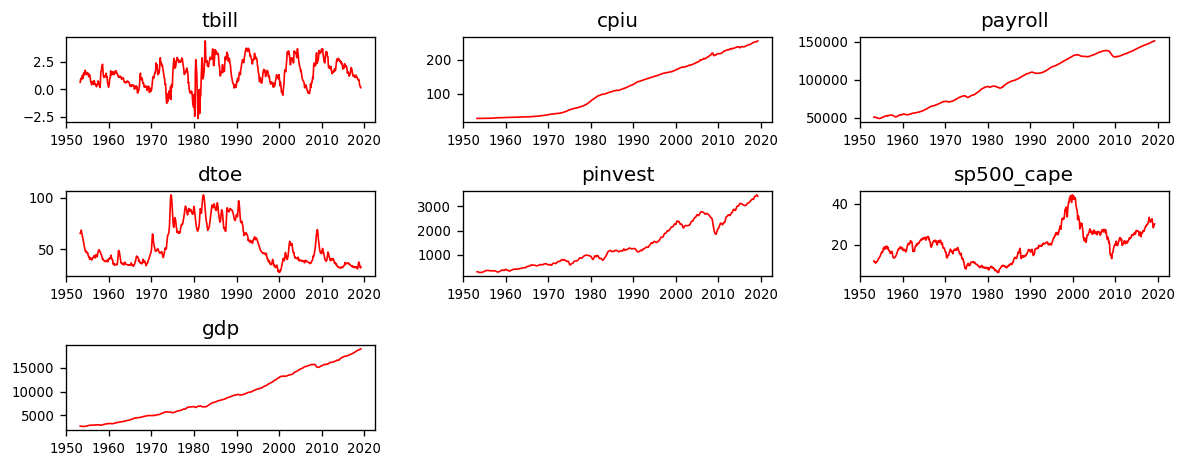

In [11]:
generate_plots(data, row_wise=True)

#### Check for Correlation

In [12]:
def generate_corr_heatmap(data_input):
    plt.figure(figsize = (10,5))
    ax = sb.heatmap(data_input.corr(), 
                    xticklabels=data_input.columns.values, 
                    yticklabels=data_input.columns.values, 
                    annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

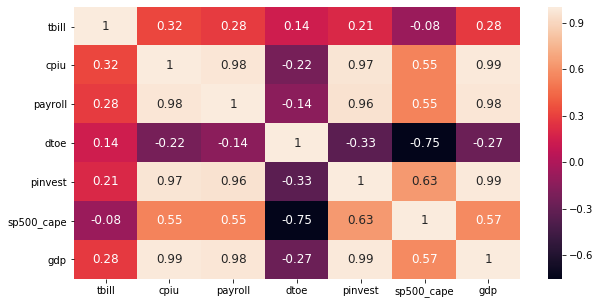

In [13]:
generate_corr_heatmap(data)

*CPIU, PAYROLL, PINEST, SP500, & GDP* are highly correlated. High correlation in input variables may cause multicollinearity. Multicollinearity reduces the statistical significance of the variables, making it difficult to pinpoint which variable is responsible for changes in GDP.

Before we decide if any variables should be removed, let's continue the exploration to gain a better picture.

#### Model Selection

For dealing with multiple variables, a vector autoregression (VAR) model can handle this problem.

VAR is a stochastic (random) process that captures linear relationship between all variables. VAR assumes all variables are dependent on each other, and that change in 1 variable will induce change in another. This trait is called Granger causality. We will verify if Granger causality exists later.

#### Test for Autocorrelation

Autocorrelation compares the lag value with all values before it, it explain how well the past and present values are related, or how well past values predict present value. Partial autocorrelation compares the lag value of the residuals, discounting the correlated portion.

GDP is highly autocorrelated. This feature can allow a generalization of GDP trend (2% year-over-year growth). We will keep this characteristic in mind as we continue the exploration.

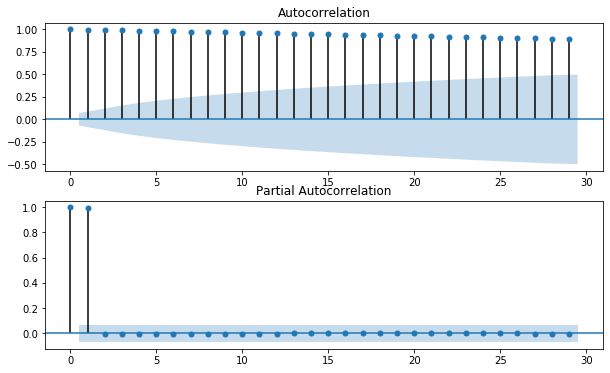

In [14]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(data.gdp, ax=ax[0])
ax[1] = plot_pacf(data.gdp, ax=ax[1])

#### Test for Stationarity

It is also important for all data to be stationary, meaning the mean and variance do not change overtime. The primary feature to eliminate is trend, for example: GDP increases steadily over the years, the mean increases as time increases, and so does the variance. Looking at the current state of *cpiu, pinvest, payroll*, and *gdp*, as time approaches infinity, so does the mean and variance. Many models do not deal with changing mean and variance very well.

In this case, if the p-value is less than 0.05, or ADF Test Statistic <= Critical Value 5%, then the series is classified as stationary.

In [15]:
class StationarityTests:
    def __init__(self, alpha=.05):
        self.SignificanceLevel = alpha
        
    def ADF_Stationarity_Test(self, timeseries):
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags','# Observations'])
        dfResults['Critical Value 5%'] = adfTest[4]['5%']

        return dfResults
        

sTest = StationarityTests()

In [16]:
for var in data:
    print(sTest.ADF_Stationarity_Test(data[var]))
    print('Is {} series stationary? {}'.format(var, sTest.isStationary))
    print('\n')

ADF Test Statistic     -5.092447
P-Value                 0.000015
# Lags                 16.000000
# Observations        776.000000
Critical Value 5%      -2.865272
dtype: float64
Is tbill series stationary? True


ADF Test Statistic      1.765773
P-Value                 0.998279
# Lags                 15.000000
# Observations        777.000000
Critical Value 5%      -2.865267
dtype: float64
Is cpiu series stationary? False


ADF Test Statistic     -0.174749
P-Value                 0.941465
# Lags                  4.000000
# Observations        788.000000
Critical Value 5%      -2.865215
dtype: float64
Is payroll series stationary? False


ADF Test Statistic     -1.102667
P-Value                 0.714007
# Lags                 21.000000
# Observations        771.000000
Critical Value 5%      -2.865296
dtype: float64
Is dtoe series stationary? False


ADF Test Statistic      0.376772
P-Value                 0.980605
# Lags                 17.000000
# Observations        775.000000
Criti

#### Data Transformation

To make our data stationary, we will take first difference of the cube root of data. Cube rooting has the benefit of reducing right skeweness, in an exponentially trending dataset, this makes the distribution more normal. **Normality is a desirable characteristic of stationarity.** However, cube rooting does not make the dataset stationary, as the trend characteristic remains, which is why differencing is needed.

Another approriate transformation method is a simple first difference. First difference method is one of the most common methods, and will work for majority of cases.

$${y} = {x_{t}}^{1/3} - {x_{t-1}}^{1/3}$$

In [17]:
# data_trans = data.diff(1).dropna()
data_cube_root = data ** (1/3) 
data_trans = data_cube_root.diff(1).dropna()

#### Normality Test (D'Agostino's K^2 Test)

In [18]:
def generate_histogram(data_input, bins, plot_name, color='blue'):
    plt.figure(figsize=(20,3))
    plt.hist(data_input, bins, color=color)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.title(str(plot_name))
    plt.show()

First Difference Transformation mean: 20.584786616161615
First Difference Transformation std.dev: 24.252443181873023
Cube Root Difference Transformation mean: 0.01746512094870466
Cube Root Difference Transformation std.dev: 0.017943607483992926


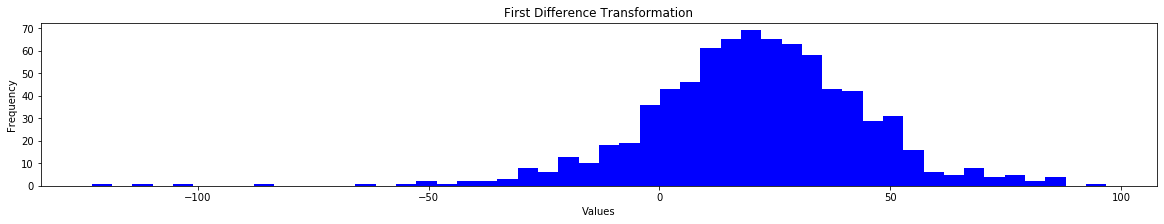

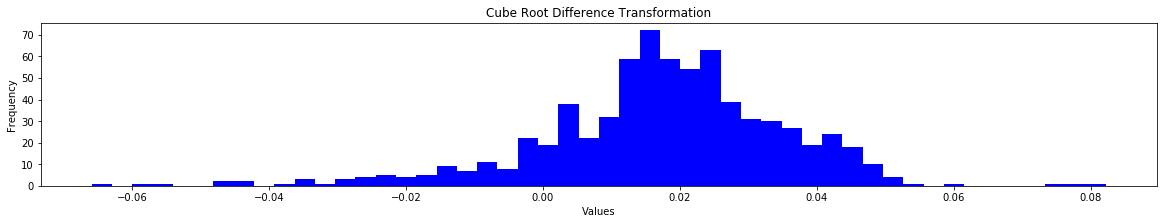

In [19]:
hist_1 = data['gdp'].diff().dropna()
hist_2 = data_trans['gdp']

print('First Difference Transformation mean:', sum(hist_1) / len(hist_1))
print('First Difference Transformation std.dev:', np.std(hist_1))
print('Cube Root Difference Transformation mean:', sum(hist_2) / len(hist_2))
print('Cube Root Difference Transformation std.dev:', np.std(hist_2))

generate_histogram(hist_1, bins=50, plot_name='First Difference Transformation')
generate_histogram(hist_2, bins=50, plot_name='Cube Root Difference Transformation')

To the naked eye, it may be difficult to discern which transformation is more normal, which is why statistical methods should be employed. D'Agostino's K^2 Test (DK2) is preferred over Shapiro-Wilks Test because _____.

DK2 computes the skewness and kurtosis. Skewness is the proportion of values in one tail vs. the other. Kurtosis is the proportion of data above 2 sigma  It then calculates how far each of these values differs from the value expected with a Gaussian distribution, and computes a single p-value from the sum of these discrepancies.

We can see that both skewness and kurtosis is less in the case of cube root than a simple difference. 

In [20]:
def dagostino_k2_test(data_input):
    s, p_skew = scipy.stats.skewtest(data_input)
    k, p_kurtosis = scipy.stats.kurtosistest(data_input)
    stat, p = scipy.stats.normaltest(data_input)
    print('skewness:', s)
    print('kurtosis:', k)
    print('s^2 + k^2 =', stat, 'p-value =', p)

In [21]:
print('First Difference Transformation:')
dagostino_k2_test(hist_1)
print('\n')

print('Cube Root Difference Transformation:')
dagostino_k2_test(hist_2)

First Difference Transformation:
skewness: -7.924189440505778
kurtosis: 8.648546598816681
s^2 + k^2 = 137.59013656092685 p-value = 1.3264212278211507e-30


Cube Root Difference Transformation:
skewness: -7.237131332832878
kurtosis: 6.389433648295601
s^2 + k^2 = 93.20093227464342 p-value = 5.776632009623415e-21


#### Splitting Data Into Trainng and Testing Sets

For training and validation, we will set the test period to 12 months prior to the latest entry.

In [22]:
test_periods = 12
train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]
train_trans.tail()

,tbill,cpiu,payroll,dtoe,pinvest,sp500_cape,gdp
date,,,,,,,
2017-12-01,-0.012513,0.004810,0.020775,-0.001697,0.029596,0.026294,0.016929
2018-01-01,0.027743,0.008292,0.020401,-0.006848,0.013713,0.039771,0.019348
2018-02-01,0.034859,0.004083,0.039326,-0.004673,-0.012089,-0.041422,0.023938
2018-03-01,-0.043943,0.001085,0.021664,-0.009954,-0.015367,-0.007618,0.024367
2018-04-01,-0.009245,0.003850,0.023311,0.013240,0.004534,-0.028139,0.027834


#### Data After Transformation

Checking for autocorrelation, much autocorrelation have been eliminated. **This means the prediction of *gdp* will be influenced more by other variables, and less by its past.**

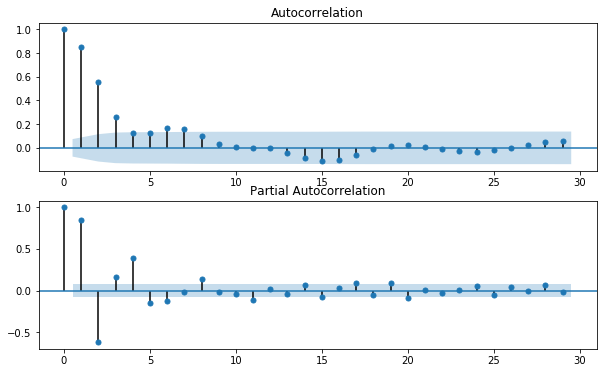

In [23]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(train_trans.gdp, ax=ax[0])
ax[1] = plot_pacf(train_trans.gdp, ax=ax[1])

The dataset is now stationary.

In [24]:
for var in train:
    sTest.ADF_Stationarity_Test(train_trans[var])
    print("Is {} series stationary? {}".format(var, sTest.isStationary))

Is tbill series stationary? True
Is cpiu series stationary? True
Is payroll series stationary? True
Is dtoe series stationary? True
Is pinvest series stationary? True
Is sp500_cape series stationary? True
Is gdp series stationary? True


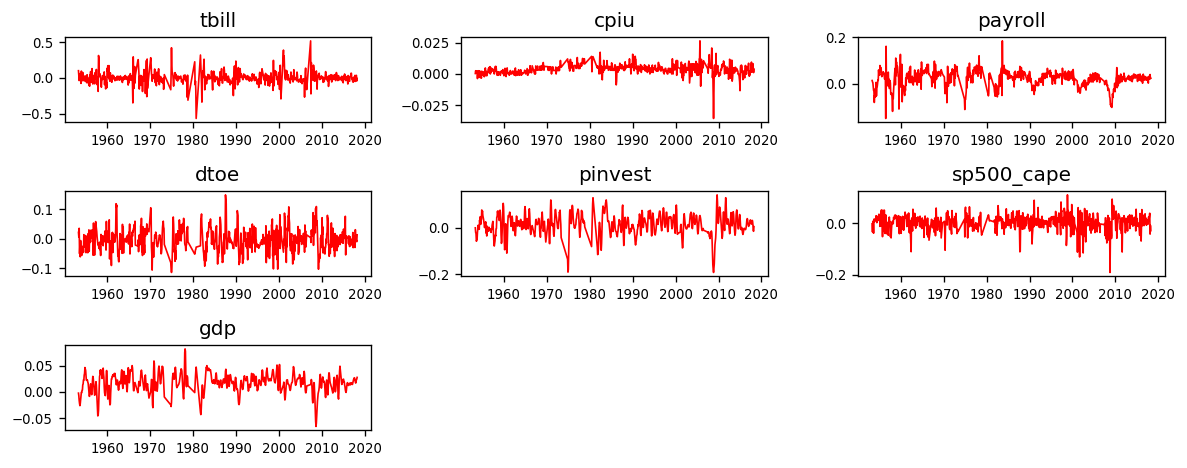

In [25]:
generate_plots(train_trans, row_wise=True)

Much of the correlation between series has been nullified after transformation, reducing multicollinearity risks.

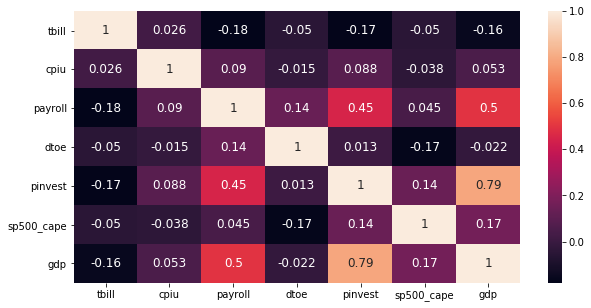

In [26]:
generate_corr_heatmap(train_trans)

#### Lag Order Selection

VAR uses [4 metrics](https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other) for [lag order selection](https://sccn.ucsd.edu/wiki/Chapter_3.5._Model_order_selection), we want the lag orders with the lowest error value: 

* Aikaike Information Criterion (AIC)- AIC is more liberal for large , complex models, and is best used for forecasting. AIC has the tendency to chooose large lag order. When lag order is too large, and may cause overfitting.
* Baysian Information Criteron (BIC)- BIC assumes reality is a candidate in the model, meaning a definitive amount of variables have definitive predictive, when a definitive lag order is used. BIC has the tendency to choose small lag order, and may cause underfitting.
* Final Prediction Error (FPE)- FPE is similar to AIC, but may outperform (lower mean squared error) than AIC in small sample sizes.
* Hannan-Quinn Information Criterion (HQIC)- Similar to BIC, but penalizes large variable selection less. 

Since we decided the economy is stochastic, and not deterministic, and since the sample size used to determine lag order is small relative to other datasets, we will use FPE.

In [27]:
print('AIC:', VAR(train_trans).fit(maxlags=24, ic='aic').k_ar)
print('BIC:', VAR(train_trans).fit(maxlags=24, ic='bic').k_ar)
print('FPE:', VAR(train_trans).fit(maxlags=24, ic='fpe').k_ar)
print('HQIC:', VAR(train_trans).fit(maxlags=24, ic='hqic').k_ar)

/home/jyuan/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


AIC: 9


/home/jyuan/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


BIC: 4


/home/jyuan/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


FPE: 9


/home/jyuan/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


HQIC: 4


#### Granger Causality Test

Granger causality test assumes there is no relationship between the lag value of x(row) and present value of y(column), if resultant p-value is greater than 0.05. If there is no causal relationship, then it means a variable has no impact on another, and it does not matter whether it is included or not.

In [28]:
lag_order = 9

def grangerstest(data_input, variables, test='ssr_chi2test'):
    res = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in data_input.columns:
        for r in res.index:
            granger_res = grangercausalitytests(data_input[[r, c]], maxlag=lag_order, verbose=False)
            p_values = [round(granger_res[i+1][0][test][1],4) for i in range(lag_order)]

            res.loc[r, c] = min(p_values)
    res.columns = [var + '_x' for var in variables]
    res.index = [var + '_y' for var in variables]
    return res

def generate_pval_map(data_input, max_lag):
    gct = grangerstest(data_input, variables=data_input.columns)
    cmap1 = ListedColormap(['r'])

    plt.figure(figsize = (10,5))
    ax = sb.heatmap(gct, 
            xticklabels=gct.columns.values, 
            yticklabels=gct.index.values, 
                mask=gct < 0.05, cmap=cmap1, cbar=False, 
                annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

The heatmap below conveys which variable x causes variable y. Pairs with p-values larger than 0.05 are deemed to have no causal relationship. This relationship can be one way, as seen in *tbill* and *sp500_cape* or two ways, exemplified by *tbill* and *cpiu*.

We want to reduce the amount of variables with no causal relations.

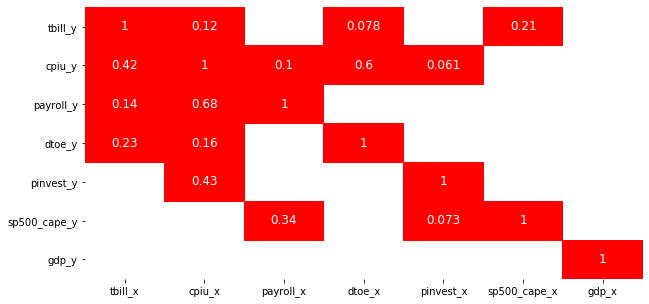

In [29]:
generate_pval_map(train_trans,  max_lag=lag_order)

#### Cointegration Test

Cointegration is simply that by lagging one variable against another (order of integration or lag order), the distance between variables is stationary through time. If two variables are cointegrated, granger causality must exist (even if a weak one, or one way causality).

Johansen test combines multiple series together, than tests whether this combined series has less order of integration than a single variable on its own. If so, then the variables are cointegrated.

Here we pass in 3 variables:
1. data to be tested,
2. 1 for stochastic nature of the data, and
3. number of lagged periods.

While there are many literature on whether the economy is [deterministic or stochastic](https://fraser.stlouisfed.org/files/docs/historical/frbsf/frbsf_let/frbsf_let_19930212.pdf), with proponents of a deterministic model arguing GDP hinders on the long term supply factors, such as capital, labor, and technology, and that growth rate should stay the same overtime; while proponents of a stochastic model would point to "permanent" changes to the growth rate, positive or negative, such as sudden sharp slope increase in supply factors since the industrial revolution. Under a deterministic model, proponents of stochastic model would say, people would still be living in the 17th century.

Testing with lag order of 9, cointegration test failed. This is due to a large number of non-causal variables. There are two ways to deal with this:
1. reduce the lag order, or
2. reduce the number of variables.

**Reducing the lag order reduces the amount of data samples fed into the model, which risks "judging a book by its cover", and making a false representation of what a variable is actually trying to tell us. Reducing the amount of variables, especially those with no or weak granger causality, is the better method.**

In [30]:
def cointegration_test(data, det_order, lag_order, significance=0.05):
    out = coint_johansen(data, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]

    def adjust(val, length=6): return str(val).ljust(length)
    print('Name   ::  Test Stat  >  C(95%)    => Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), '> ', adjust(cvt, 8), ' => ', trace > cvt)

cointegration_test(train_trans, det_order=-1, lag_order=lag_order)

Name   ::  Test Stat  >  C(95%)    => Signif  
 ----------------------------------------
tbill  ::  424.86    >  111.7797  =>  True
cpiu   ::  303.53    >  83.9383   =>  True
payroll ::  219.67    >  60.0627   =>  True
dtoe   ::  145.65    >  40.1749   =>  True
pinvest ::  88.72     >  24.2761   =>  True
sp500_cape ::  42.36     >  12.3212   =>  True
gdp    ::  2.35      >  4.1296    =>  False


Below is a modified function to find the highest lag order that satisfies the cointegration test, if none are found, it will return the lag order that minimizes FPE.

In [31]:
def cointegration_test_lag_order_detection(data_input, det_order, lag_order, significance=0.05):
    out = coint_johansen(data, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]
    return traces > cvts

def set_coint_lag_order(data_input, det_order, max_lag, significance=0.05):
    for i in reversed(range(0, max_lag)):
        if all(cointegration_test_lag_order_detection(data_input, det_order=-1, lag_order=i)) == True:
            return i
        else:
            '''if all return false, use FPE values from model selection'''
            model = VAR(data_input)
            model_fitted = model.fit(maxlags=24, ic='fpe')
            return model_fitted.k_ar

#### Dimensionality Reduction

**When removing variables, we want to:
1. ensure some unique features are retained,
2. ensure granger causality exists (at least one way), and
3. maximize final Test Stat.

Considering the above conditions, *cpiu*, and *pinvest* are removed, while *tbill* and *sp500_cape* were considered for removal, but ultimately retained. While the case cannot be made regarding uniqueness, as the variables were already selected to "represent various aspects or mechanisms of the economy", the inclusion of both *tbill* and *sp500_cape* actually increases the final Test Stat against other combinations, meaning the model is more cointegrated overall with these variables than without.

We want first reduce the varaibles causing the most non-cointegratedness.

In [32]:
gct = grangerstest(train_trans, train_trans.columns)
print('Sum of p-value greater than 0.05 on both axis:')
print(pd.DataFrame([gct.sum().sort_values(ascending=False), gct.sum(axis=1).sort_values(ascending=False)]))

Sum of p-value greater than 0.05 on both axis:
   cpiu_x  tbill_x  dtoe_x  payroll_x  sp500_cape_x  pinvest_x   gdp_x  \
0  2.4069   1.8135  1.6781     1.4451        1.2074     1.1584  1.0225   
1     NaN      NaN     NaN        NaN           NaN        NaN     NaN   

   cpiu_y  payroll_y  sp500_cape_y  pinvest_y  dtoe_y  tbill_y   gdp_y  
0     NaN        NaN           NaN        NaN     NaN      NaN     NaN  
1  2.1948     1.8192        1.4428     1.4291  1.4192   1.4114  1.0154  


In [35]:
train_trans = train_trans.drop(['cpiu'], axis=1)
gct = grangerstest(train_trans, train_trans.columns)
print('Sum of p-value greater than 0.05 on both axis:')
print(pd.DataFrame([gct.sum().sort_values(ascending=False), gct.sum(axis=1).sort_values(ascending=False)]))

Sum of p-value greater than 0.05 on both axis:
   tbill_x  payroll_x  sp500_cape_x  pinvest_x  dtoe_x   gdp_x  sp500_cape_y  \
0   1.3943     1.3448         1.207     1.0974  1.0791  1.0076           NaN   
1      NaN        NaN           NaN        NaN     NaN     NaN        1.4404   

   tbill_y  dtoe_y  payroll_y   gdp_y  pinvest_y  
0      NaN     NaN        NaN     NaN        NaN  
1   1.2867  1.2561      1.144  1.0029     1.0001  


Putting everything together, 

The optimal lag order after variable reduction is 18.

In [ ]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500_cape, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

data = data.drop(['tbill', 'cpiu'], axis=1)
data_cube_root = data ** (1/3)
data_trans = data_cube_root.diff(1).dropna()

train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]

lag_order = set_coint_lag_order(train_trans, det_order=-1, max_lag=36, significance=0.05)
print('lag order:', lag_order)

In [ ]:
print(cointegration_test(train_trans, det_order=-1, lag_order=lag_order))

generate_pval_map(train_trans, max_lag=lag_order)

### VAR Model

Running the following functions returns the VAR model. 

In [ ]:
train_model = VAR(train_trans)
train_model_fitted = train_model.fit(lag_order)
train_model_fitted.summary()

#### Check for Residual Correlation with Durbin Watson Test

If our transformation and lag order selection is done correctly, there should be little to no correlation between the residual errors. The existance of residual correlation implies unexplained pattern.

Result values can range beween 0 to 4, with 0-2 indicating a positive correlation, and 2-4 indicating negative correlation. It is generally acceptable for values to be between 1.5 to 2.5.

In [ ]:
for col, val in zip(train_trans.columns, durbin_watson(train_model_fitted.resid)):
    print((col), ':', round(val, 2))

#### Forecasting GDP

VAR model only takes in data specified within the lag order (18 samples). A common misunderstanding is that information outside of the specified range is lost, but this is not the case. The model does assumes data outside of the lag order to be irrelevant, because all 793 samples were fed into the model to derive the lag order.

In [ ]:
train_forecast_input = train_trans.values[-lag_order:]

train_forecast = pd.DataFrame(train_model_fitted.forecast(train_forecast_input, test_periods), 
                        index=data.index[-test_periods:], 
                        columns=data.columns)

train_forecast

#### Inverting Transformation

We have to reverse the first difference transformation, then add the baseline. Since we want to validate against the test dataset, we add back the last known training data.

In [ ]:
train_trans_cumsum = train_trans.cumsum()
train_trans_cumsum.tail()

train_forecast_reverse = (train_forecast.cumsum() + train_trans_cumsum.iloc[-1, :] + data_cube_root.iloc[0, :]) ** 3
train_forecast_reverse

In [ ]:
fig, axes = generate_subplots(train_forecast_reverse, row_wise=True)
for i, (col,ax) in enumerate(zip(train_forecast_reverse.columns, axes.flatten())):
    train_forecast_reverse[col].plot(color='red', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col].plot(color='blue', label='actual', legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.tick_params(which='major', labelsize=8)
    ax.tick_params(which='minor', labelsize=6)
    ax.legend(loc='upper left', fontsize=6)

plt.tight_layout();

At first glance, the model may exibit underfitting in *dtoe* and *sp500_cape*. To evaluate the model's accuracy, it is evaluated according to the following metrics:
* Mean Absolute Percentage Error (MAPE)- Accuracy expressed as a percentage, the lower the value, the greater the accuracy. However, MAPE is not a good metric for tbill, as actual (denominator) approaches zero, the value of MAPE approaches infinity.
* Correlation (CORR)- Correlation between prediction and actual data. Low values may suggest underfitting, while high values may suggest overfitting.

Since we are not comparing between models, it is irrelevant to calculate Mean Absolute Error and Root Mean Squared Error.

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
#     mae = np.mean(np.abs(forecast - actual))
#     rmse = np.mean((forecast - actual) ** 2) ** .5
    corr = np.corrcoef(forecast, actual)[0,1]
    return({'MAPE':mape, 'CORR':corr})
#     return({'MAPE':mape, 'MAE': mae, 'RMSE':rmse, 'CORR':corr, 'MINMAX':minmax})

In [ ]:
def print_forecast_accuracy(forecast, actual):
    for c in forecast:
        print('Forecast Accuracy of {}'.format(c))
        accuracy_prod = forecast_accuracy(forecast[c].values, actual[c])
        for k, v in accuracy_prod.items():
            print(k, ': ', round(v,4))
        print('\n')

print_forecast_accuracy(forecast=train_forecast_reverse, actual=test)

#### Consolidate Formula

To save time testing new parameters, let's consolidate the processing into a single function, at the same time expanding the amount of models it can generate at the same time to 4. Recessions generally do not last more than 2 years, so having 1 year prior and 1 year after helps to predict the onset and recovery. 

In [ ]:
def var_combined_processing(data_input, lag_order, start_date, test_periods):
    '''return start date'''
    start_date = pd.to_datetime(start_date)
    '''return dates for graphing'''
    data_baseline = data_input.loc[(data_input.index >= start_date - relativedelta(months=ceil(2 * test_periods))) & 
                                    (data_input.index <= start_date + relativedelta(months=ceil(2 * test_periods)))]
    '''transform first difference'''
    data_cube_root = data_input ** (1/3)
    data_trans = data_cube_root.diff(1).dropna()
    data_trans = data_trans.loc[data_trans.index <= start_date]
    '''VAR model'''
    model_fitted = VAR(data_trans).fit(lag_order)
    forecast_trans = pd.DataFrame(
        model_fitted.forecast(data_trans.values[-lag_order:], test_periods), 
        index=data_trans.index[-test_periods:], columns=data_trans.columns)
    '''invert transformation'''
    data_trans_cumsum = data_trans.iloc[data_trans.index <= start_date].squeeze().cumsum()
    forecast_reverse = (forecast_trans.cumsum() + data_trans_cumsum.iloc[-1, :].squeeze() + data_cube_root.iloc[0, :]) ** 3
    forecast_reverse.index = pd.date_range(start_date + relativedelta(months=1), start_date + 
                                           relativedelta(months=test_periods), freq='MS')
#     return data_trans_cumsum
    return data_baseline, forecast_reverse

def var_combined(data_input, lag_order, start_date_1, start_date_2=None, start_date_3=None, start_date_4=None, test_periods=(2*lag_order)):
    data_baseline, forecast_reverse_1 = var_combined_processing(data_input, lag_order, start_date_1, test_periods)
    if start_date_2:
        data_baseline_2, forecast_reverse_2 = var_combined_processing(data_input, lag_order, start_date_2, test_periods)
        data_baseline.append(data_baseline_2)
    if start_date_3:
        data_baseline_3, forecast_reverse_3 = var_combined_processing(data_input, lag_order, start_date_3, test_periods)
        data_baseline.append(data_baseline_3)
    if start_date_4:
        data_baseline_4, forecast_reverse_4 = var_combined_processing(data_input, lag_order, start_date_4, test_periods)
        data_baseline.append(data_baseline_4)
        
    '''display graphs'''
    fig, axes = generate_subplots(data_input, row_wise=True)
    for i, (col,ax) in enumerate(zip(forecast_reverse_1.columns, axes.flatten())):
        data_baseline[col].plot(color='blue', label='actual', legend=True, ax=ax)
        forecast_reverse_1[col].plot(color='yellow', label=start_date_1, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_2:
            forecast_reverse_2[col].plot(color='orange', label=start_date_2, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_3:
            forecast_reverse_3[col].plot(color='red', label=start_date_3, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_4:
            forecast_reverse_4[col].plot(color='brown', label=start_date_4, legend=True, ax=ax).autoscale(axis='x',tight=True);

        ax.set_title(col + ": Forecast")
        ax.tick_params(which='major', labelsize=8)
        ax.tick_params(which='minor', labelsize=6)
        ax.legend(loc='upper left', fontsize=6)
        plt.tight_layout();

#### Forecasting

In [ ]:
var_combined(data, lag_order=lag_order, start_date_1='2019, 4', test_periods=24)

### Backtesting Against Past Recessions

We will pick certain recessions to test our model, with different length of test periods relative to the length of the recession. 

#### 1973 Recession

NBER classified 1973 recession from 1973/11 to 19735/3. This recession was caused by the Nixon Shock and oil supply shock, in contrast to to a typical recession, which are caused by overextension of credit.

In [ ]:
var_combined(data, lag_order=lag_order, start_date_1='1972, 11', start_date_2='1973, 11',
             start_date_3='1974, 11', start_date_4='1975, 11', test_periods=48)

#### 2001 Recession

NBER classified 2001 recession from 2001/3 to 2001/11. This recession was relatively mild.

In [ ]:
var_combined(data, lag_order=lag_order, start_date_1='2000, 3', start_date_2='2001, 3',
             start_date_3='2002, 3', test_periods=36)

#### 2008 Recession

NBER classified 2008 recession from 2007/12 to 2009/6.

In [ ]:
var_combined(data, lag_order=lag_order, start_date_1='2006, 12', start_date_2='2007, 12',
             start_date_3='2008, 12', start_date_4='2009, 12', test_periods=48)

## Findings

The model inherits characteristics of its input lag data, and the data before a recession tends to be stable (same slope/low monthly difference) until the start of a recession. This leads to the model being ineffective at predicting the start of a recession, but could explain why the model performs better at predicting the recovery of a recession.

The model have diminished accuracy after roughly 2 lag order periods have passed. 

## Limitations

### Feature Selection

This predictor does not pinpoint the cause of a recession, but makes a general comment about the state of the economy. The underlying assumption is that these inputs are efficient enough to reflect long term market conditions, but inefficient enough to price in the short term fluctuations in the variables.

### Data Tranformation

VAR requires data to be stationary and cointegration, but [not all transformation methods are created equal](http://fmwww.bc.edu/repec/bocode/t/transint.html). The method chosen have a direct impact on the result. Also, whether we should discriminate different transformation method on each variable is still hotly debated among the data science community.

### VAR Model

**The VAR model here is a reduced form version, which helps to overcome parameter identification problem, where it becomes impossible to identify the best estimate of a variable, due to the sharing of **

## Conclusion

To truly know which variables, processes, and methods are optimal, is by quickly deploying models and compare against each other, instead of 

## Part 2

#### Data Preparation

Let's set up recession decision variable. Difficulty joining series, so had to convert to list, append, then reconvert to series.

In [ ]:
# possible to create lambda variables?
r_1953 = pd.Series(pd.date_range(pd.to_datetime('1953, 3, 1'), pd.to_datetime('1954, 5, 1'))).tolist()
r_1957 = pd.Series(pd.date_range(pd.to_datetime('1957, 8, 1'), pd.to_datetime('1958, 4, 1'))).tolist()
r_1960 = pd.Series(pd.date_range(pd.to_datetime('1960, 4, 1'), pd.to_datetime('1961, 2, 1'))).tolist()
r_1962 = pd.Series(pd.date_range(pd.to_datetime('1969, 12, 1'), pd.to_datetime('1970, 11, 1'))).tolist()
r_1973 = pd.Series(pd.date_range(pd.to_datetime('1973, 11, 1'), pd.to_datetime('1975, 3, 1'))).tolist()
r_1980 = pd.Series(pd.date_range(pd.to_datetime('1980, 1, 1'), pd.to_datetime('1980, 7, 1'))).tolist()
r_1981 = pd.Series(pd.date_range(pd.to_datetime('1981, 7, 1'), pd.to_datetime('1982, 11, 1'))).tolist()
r_1990 = pd.Series(pd.date_range(pd.to_datetime('1990, 7, 1'), pd.to_datetime('1991, 3, 1'))).tolist()
r_2001 = pd.Series(pd.date_range(pd.to_datetime('2001, 3, 1'), pd.to_datetime('2001, 11, 1'))).tolist()
r_2007 = pd.Series(pd.date_range(pd.to_datetime('2007, 12, 1'), pd.to_datetime('2009, 6, 1'))).tolist()

print('Original series length:', len(r_1953))

recession_months = pd.Series(r_1953 + r_1957 + r_1960 + r_1962 + r_1973 + r_1980 + r_1981 + r_1990 + r_2001 + r_2007)

# Create a DataFrame for recession
start_date = pd.to_datetime('1953, 4')
end_date = pd.to_datetime('today')
recessions = pd.date_range(start_date, end_date, freq='MS')
recessions = recessions.to_frame().reset_index()

# Mark recession months as 1, non-recession months as 0
recessions.iloc[:,1] = 0
recessions.loc[recessions.iloc[:,0].isin(recession_months), 0] = 1
recessions.rename(columns={'index':'date', 0:'recession'}, inplace=True)


print('Verify series was appended:', len(recession_months))

recessions.iloc[15:20]